<a href="https://colab.research.google.com/github/ChelseaOwiti/Colposcopy-Scan/blob/main/draft4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Project
%ls

/content/drive/MyDrive/Project
assets/       draft1_model.h5           keras_metadata.pb   resnet50_model.h5
d2_model.h5   draft2.ipynb              logs/               saved_model.pb
d3_model.h5   h5_model.h5               model.tflite        variables/
data/         imagenet_draft3_model.h5  output/
draft1.ipynb  imagenet_model.h5         resnet152_model.h5


In [2]:
trainpath = 'data/train'
valpath = 'data/val'
testpath = 'data/test'

In [3]:
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import pathlib

In [4]:
train_dir = pathlib.Path(trainpath)
test_dir = pathlib.Path(valpath)

print(str(len(list(train_dir.glob('*/*.jpg'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.jpg')))) + ' Testing Images')

888 Training Images
296 Testing Images


In [5]:
batch_size = 32  
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 800 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 888 files belonging to 3 classes.
Using 88 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Type_1', 'Type_2', 'Type_3']


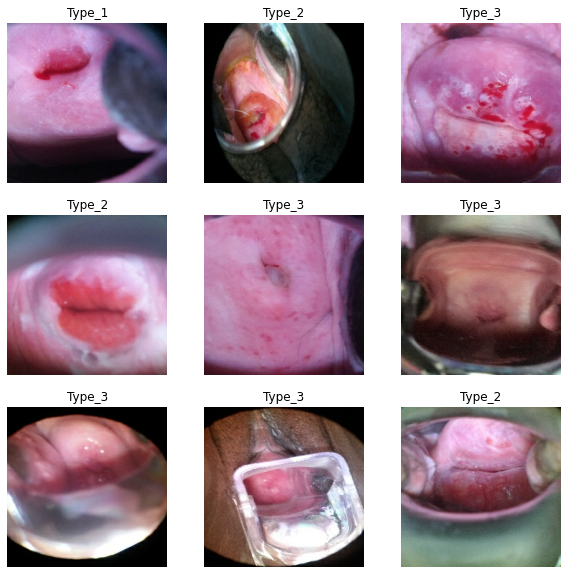

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [17]:
for image_batch, labels_batch in train_ds: #image batch is a tensor of the shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [18]:
num_classes = len(class_names)
print(num_classes)

3


In [19]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
     

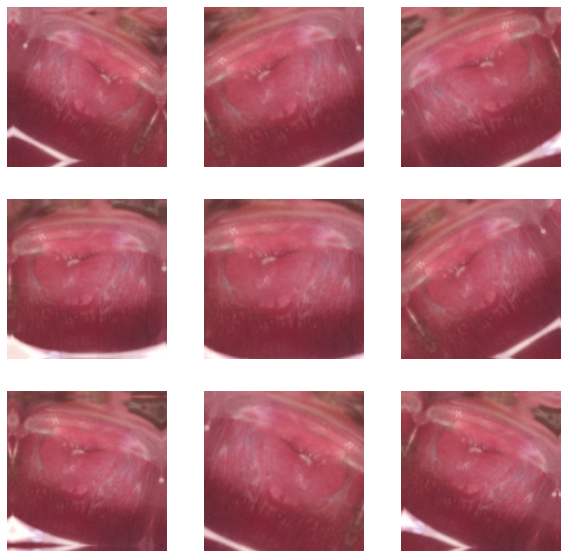

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [54]:
num_classes = len(class_names)
resnet_model = Sequential([
    resize_and_rescale,
  data_augmentation
]
    
)

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes= num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [43]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
# #Early stopping to avoid overfitting of model

In [55]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [56]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [57]:
resnet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])



In [61]:
epochs = 10
history = resnet_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs,
    shuffle=True)

Epoch 1/10
25/25 [==============================] - 3s 132ms/step - loss: 1.0198 - accuracy: 0.5175 - val_loss: 1.0340 - val_accuracy: 0.5227
Epoch 2/10
25/25 [==============================] - 3s 133ms/step - loss: 1.0300 - accuracy: 0.5125 - val_loss: 0.9782 - val_accuracy: 0.5682
Epoch 3/10
25/25 [==============================] - 3s 134ms/step - loss: 1.0124 - accuracy: 0.5038 - val_loss: 0.9775 - val_accuracy: 0.5682
Epoch 4/10
25/25 [==============================] - 3s 136ms/step - loss: 1.0080 - accuracy: 0.5138 - val_loss: 0.9810 - val_accuracy: 0.5568
Epoch 5/10
25/25 [==============================] - 3s 134ms/step - loss: 1.0115 - accuracy: 0.5225 - val_loss: 1.1401 - val_accuracy: 0.2841
Epoch 6/10
25/25 [==============================] - 3s 133ms/step - loss: 1.0429 - accuracy: 0.4762 - val_loss: 1.0309 - val_accuracy: 0.5682
Epoch 7/10
25/25 [==============================] - 3s 132ms/step - loss: 1.0483 - accuracy: 0.4725 - val_loss: 1.0309 - val_accuracy: 0.5227
Epoch 

In [ ]:
resnet_model.summary()

Model Evaluation

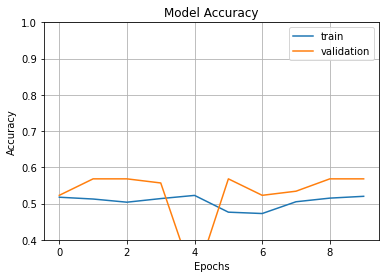

In [62]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

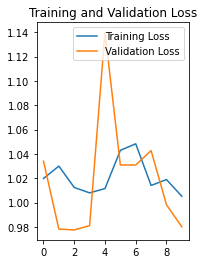

In [63]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions

In [64]:
#Type 1 Predictions
test_image = '/content/drive/MyDrive/Project/data/train/Type_1/1013.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 1s/step
This image most likely belongs to Type_2 with a 28.37 percent confidence.


In [65]:
#Type 2
test_image = '/content/drive/MyDrive/Project/data/val/Type_2/1010.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to Type_2 with a 27.79 percent confidence.


In [66]:
test_image = '/content/drive/MyDrive/Project/data/val/Type_3/1029.jpg'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Type_2 with a 29.61 percent confidence.


In [59]:
import seaborn as sns

In [60]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix


In [61]:
#predict
# img = tf.keras.utils.load_img(
#     test_image, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# y_pred=resnet_model.predict(test_ds)
# y_pred=np.argmax(y_pred,axis=1)



1/1 [==============================] - 14s 14s/step


In [ ]:
# newShape = (224, 224)
# test_ds = tf.reshape(test_ds, newShape)
# conf_mat = confusion_matrix(y_true = test_ds, y_pred= y_pred)


In [ ]:
# print(confusion_matrix(y_pred, img_array))